In [1]:
import numpy as np
import jax.numpy as jnp
from jax import jit

In [14]:
# Build a toy discriminant

obs_sig = np.random.normal(loc=3.0, scale=0.5, size=1000)
obs_bkg = np.random.normal(loc=1.0, scale=0.5, size=1000)

In [15]:
hist_sig, bins = np.histogram(obs_sig)
hist_bkg, bins = np.histogram(obs_bkg)

In [16]:
print(hist_sig)
print(hist_bkg)

[  7  26 131 204 273 214  95  37  11   2]
[  5  17  59 107 222 259 183 108  31   9]


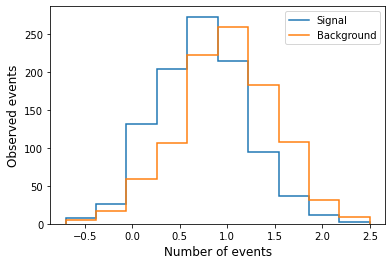

In [22]:
import mplhep as hep
from matplotlib import pyplot as plt

hep.histplot(hist_sig, bins, label='Signal')
hep.histplot(hist_bkg, bins, label='Background')

plt.xlabel('Number of events', size=12)
plt.ylabel('Observed events', size=12)
plt.legend(loc='upper right')

In [29]:
# Build test statistic

#Calculate the overall yield based on the value of signal strength mu

@jit
def sigma(mu, hist_sig, hist_bkg):
    
    sigma_mu_binned = mu*hist_sig+hist_bkg                     
                        
    return sigma_mu_binned

In [34]:
print(sigma(1.0, hist_sig, hist_bkg))

[ 12.  43. 190. 311. 495. 473. 278. 145.  42.  11.]


In [35]:
N_obs_Asimov = hist_sig + hist_bkg
print(N_obs_Asimov)

[ 12  43 190 311 495 473 278 145  42  11]


In [55]:
def NLL(mu, hist_sig, hist_bkg):
    
    sigma_mu = sigma(mu, hist_sig, hist_bkg)

    llr = jnp.array([-2*N_obs*jnp.log(sigma_mu)+2*sigma_mu]).sum()
    
    return llr


In [56]:
print(NLL(2.0, hist_sig, hist_bkg) - NLL(1.0, hist_sig, hist_bkg))

394.81445


In [57]:
def NLL_minuit(mu):
    
    return NLL(mu, hist_sig, hist_bkg)

In [54]:
from iminuit import Minuit
from jax import grad

m1 = Minuit(jit(NLL_minuit), jnp.array([1.0]), grad=jit(grad(NLL_minuit)))
m1.errordef = Minuit.LEAST_SQUARES
m1.strategy = 0
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.886e+04                 │               Nfcn = 9               │
│ EDM = 0.000488 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   1.000   │   0.015   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────┐
│    │      mu │
├────┼─────────┤
│ mu │ 0.00023 │
└────┴─────────┘

In [59]:
%%timeit

m1 = Minuit(NLL_minuit, jnp.array([1.0]), grad=grad(NLL_minuit))
m1.errordef = Minuit.LEAST_SQUARES
m1.strategy = 2
m1.migrad()

8.4 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
%%timeit

m1 = Minuit(jit(NLL_minuit), jnp.array([1.0]), grad=jit(grad(NLL_minuit)))
m1.errordef = Minuit.LEAST_SQUARES
m1.strategy = 2
m1.migrad()

944 µs ± 6.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
